In [187]:
import os
import re

from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

from pandas.plotting import scatter_matrix

%run model.py
%run plotPerformance.py
%run paramPipeline.py
%run betweenCompare.py

%matplotlib inline

np.random.seed(1234)

# Load Data

In [2]:
# Load transformed data
cwd = os.getcwd()
datadir = cwd + os.sep + 'data' + os.sep

data = pd.read_csv(datadir + "complete.csv", index_col = 0)

# Feature Selection

In [3]:
#Drop reputation-based features
data2 = data.drop(["followers_count", "friends_count"], axis = 1)

In [4]:
#Drop highly correlated features
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return(dataset)

#Ignore mv features
mv_cols = list(data.filter(like='mv').columns)
mv_cols
data_mv = data[data.columns.difference(mv_cols)]

data3 = correlation(data_mv, 0.75)

In [5]:
#three models to test the datasets
dt_data = DecisionTreeClassifier(criterion="entropy", random_state = 1234)
lr_data = LogisticRegression(random_state = 1234)

data_choosers = {'data': data, 'data2': data2, 'data3': data3}

kfolds = KFold(10, True, random_state = 1234)


In [6]:
#Choose data set with highest mean auc
for dataset in data_choosers:
    aucs = list(cross_val_score(dt_data, data_choosers[dataset].drop('label',1), data_choosers[dataset].label, cv = kfolds, scoring="roc_auc"))
    aucs.extend(cross_val_score(lr_data, data_choosers[dataset].drop('label',1), data_choosers[dataset].label, cv = kfolds, scoring="roc_auc"))
    
    print("For {0}, mean auc is {1}:".format(dataset, np.round(np.mean(aucs), decimals = 3))) 

For data, mean auc is 0.716:
For data2, mean auc is 0.723:
For data3, mean auc is 0.716:


In [7]:
# Train test split
X_train, X_test, y_train, y_test = ms.train_test_split(data2.drop('label', 1), data2.label, test_size=0.2, random_state = 1234)

In [8]:
dt = Model("Decision Tree", DecisionTreeClassifier(criterion="entropy", random_state = 1234), X_train, y_train, X_test, y_test)

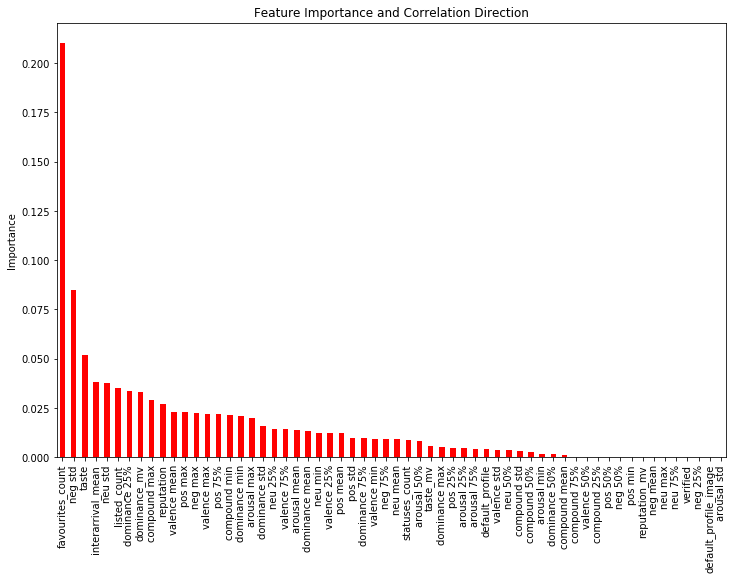

In [9]:
# Get importance and correlation
features_summary = pd.DataFrame(list(zip(X_train.columns, dt.best_iteration.model.feature_importances_)), 
                                columns=['feature','importance']).set_index('feature')
features_summary = features_summary.sort_values('importance', ascending=False)

corr_df = pd.DataFrame(data.corr()['label'][:-1])
corr_df.columns = ['correlation']

features_summary = features_summary.merge(corr_df, right_index=True, left_index=True)

# Plot importance and correlation
color_list = ['r' if corr < 0 else 'g' for corr in features_summary.correlation]
features_summary.importance.plot(kind='bar', color=color_list, figsize=(12,8))
plt.title('Feature Importance and Correlation Direction')
plt.ylabel('Importance')

# Select features
keep_features = features_summary[features_summary.importance > 0].index.values

# EDA

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000261D87547F0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000261DC3F7128>]], dtype=object)

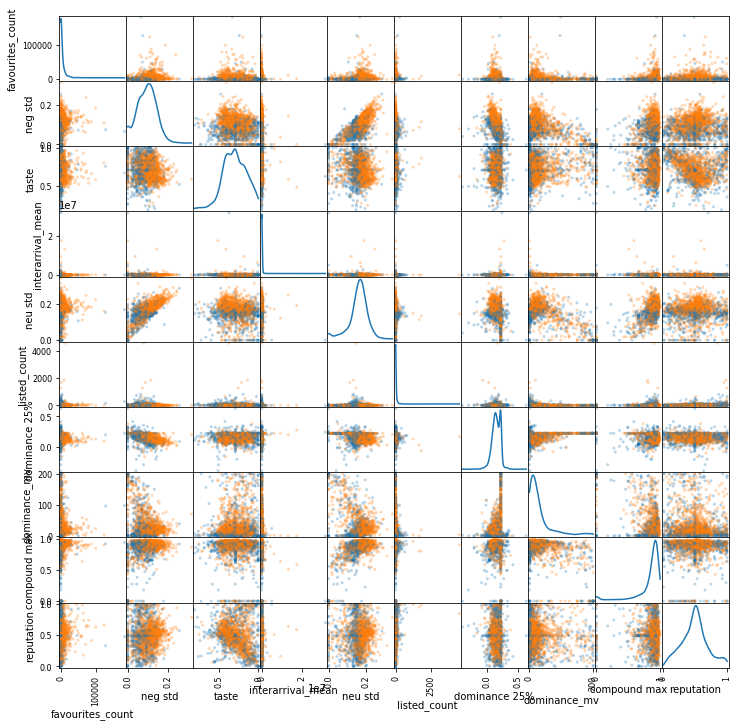

In [10]:
eda_data = X_train.copy()
eda_y = y_train.copy()

scatter_matrix(eda_data[features_summary.head(10).index], alpha=0.3, figsize=(12, 12), diagonal='kde',
              color=np.where(eda_y==1,'C0','C1'))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000261D866B390>,
        ...,
        ...,
        ...,
       ..., 
        ...,
        ...,
        ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002619D582198>]], dtype=object)

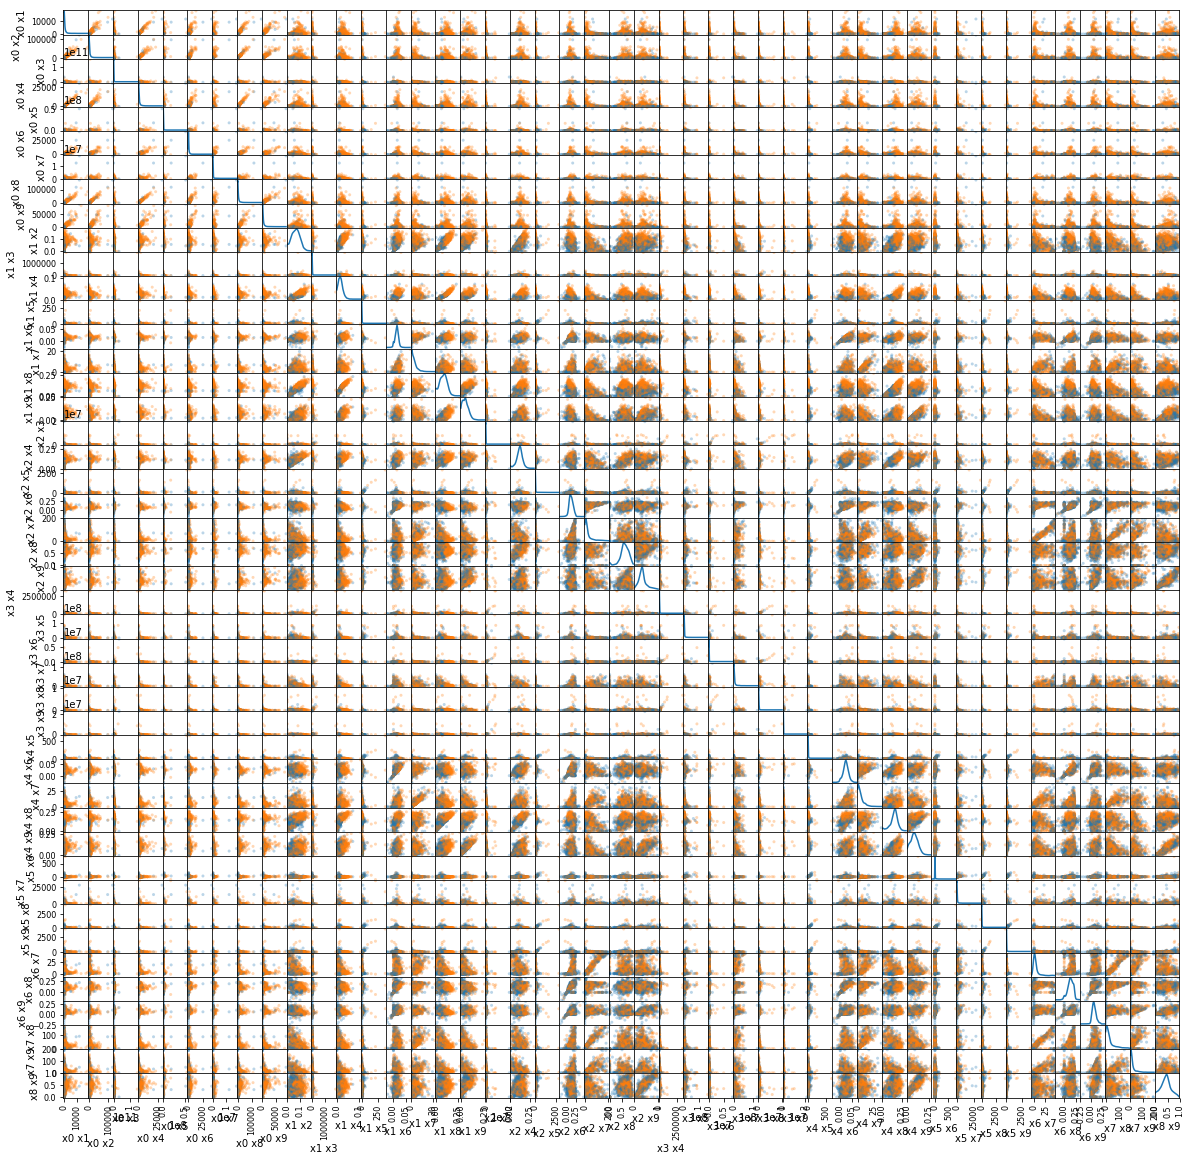

In [11]:
poly = PolynomialFeatures(degree=2, interaction_only=True)
eda_poly = pd.DataFrame(poly.fit_transform(eda_data[features_summary.head(10).index]),
                           columns=poly.get_feature_names(),
                           index = eda_data.index)

scatter_matrix(eda_poly.iloc[:,11:], alpha=0.3, figsize=(20, 20), diagonal='kde',
              color=np.where(eda_y==1,'C0','C1'))

# Train Baseline Model

In [12]:
# Discard features
X_train_filt = X_train[keep_features]
X_test_filt = X_test[keep_features]

#Scale scalable features
scalable = X_train_filt[X_train_filt.columns.difference(mv_cols)].select_dtypes(exclude = ["bool"]).columns
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_filt[scalable].copy())

X_trained = X_train_filt.copy()
X_tested = X_test_filt.copy()


X_trained[scalable] = scaler.transform(X_trained[scalable])
X_tested[scalable] = scaler.transform(X_tested[scalable])

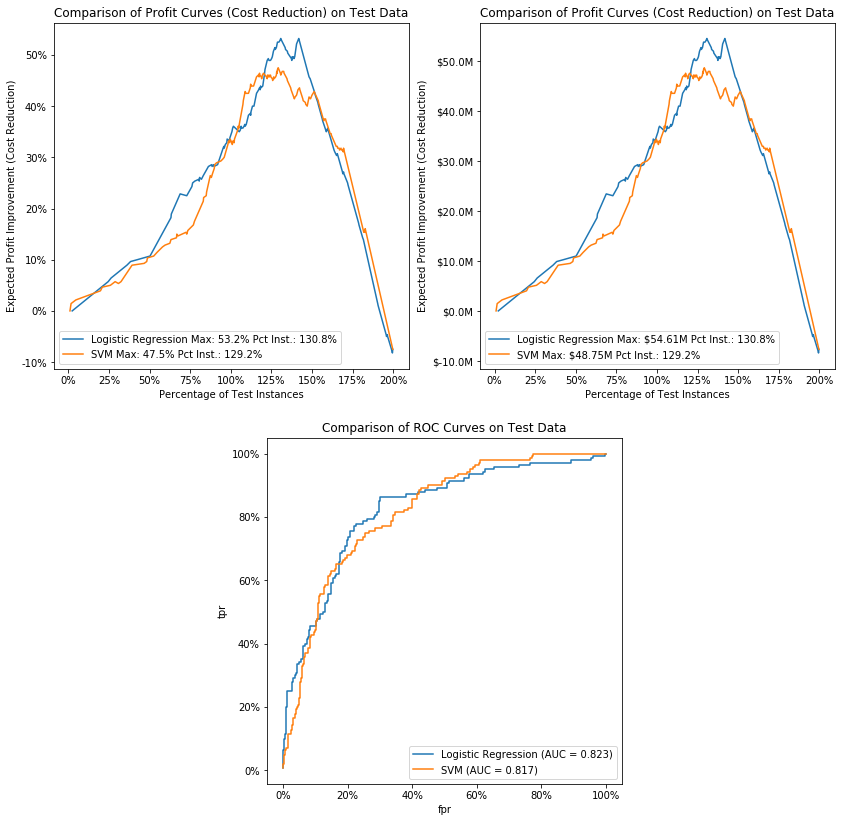

In [13]:
# Baseline Logistic Regression and SVM
lr = Model("Logistic Regression", LogisticRegression(C=1e30, random_state = 1234), X_trained, y_train, X_tested, y_test)
svm = Model("SVM", SVC(probability = True, random_state = 1234), X_trained, y_train, X_tested, y_test)
plotPerformance([lr,svm])

# Pipelines

# Logistic Regression

## Model Initialization

In [188]:
poly = PolynomialFeatures(2)

X_trained_poly = poly.fit_transform(X_trained)
X_tested_poly = poly.transform(X_tested)

In [189]:
lrc = Model("LR", LogisticRegression(random_state = 1234), X_trained_poly, y_train, X_tested_poly, y_test)

## Iteration 1

Best Score: 0.787147

Best Params:  {'estimator__C': 0.01}


{'C': 0.001}

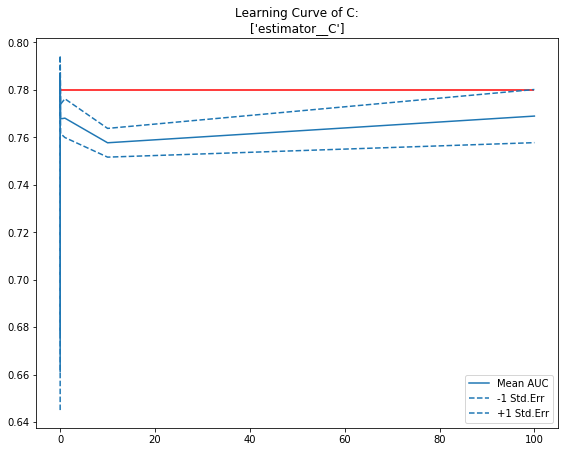

In [190]:
lrc.addIteration("C", LogisticRegression(**lrc.parameters), 
                {'estimator__C': [10**x for x in range(-8,3)]}, 
                 reg = True, plot = True)

lrc.parameters

# SVM

## Model Initialization

In [191]:
svm = Model("SVM", SVC(probability = True, random_state = 1234), X_trained, y_train, X_tested, y_test)

svm.parameters['probability'] = True

## Iteration 1

In [192]:
svm.addIteration("Kernel", SVC(**svm.parameters), 
                {'estimator__kernel': ['linear','rbf','sigmoid']},
                plot = False)

svm.parameters

Best Score: 0.808336

Best Params:  {'estimator__kernel': 'rbf'}


{'kernel': 'rbf', 'probability': True}

## Iteration 2

Best Score: 0.808336

Best Params:  {'estimator__C': 1}


{'C': 0, 'kernel': 'rbf', 'probability': True}

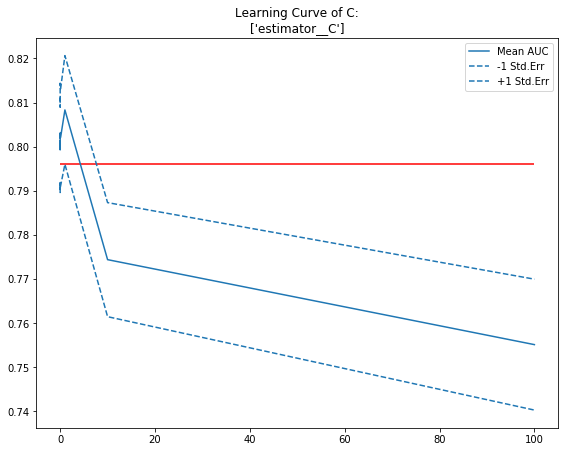

In [193]:
svm.addIteration("C", SVC(**svm.parameters), 
                {'estimator__C': [10**x for x in range(-8,3)]}, 
                 reg = True, plot = True)

svm.parameters

# GBM 

## Model Initialization

In [194]:
gbc = Model("GBC", GradientBoostingClassifier(random_state = 1234), X_trained, y_train, X_tested, y_test)

 ## Iteration 1

Best Score: 0.851942

Best Params:  {'estimator__n_estimators': 50}


{'n_estimators': 30}

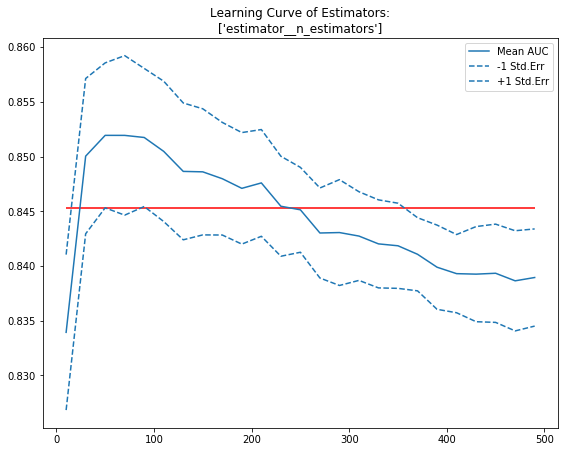

In [195]:
gbc.addIteration("Estimators", GradientBoostingClassifier(**gbc.parameters),
                {'estimator__n_estimators': list(range(10,500,20))}, 
                 reg = True, plot = True)
gbc.parameters

## Iteration 2 

Best Score: 0.849298

Best Params:  {'estimator__max_depth': 3}


{'max_depth': 2, 'n_estimators': 30}

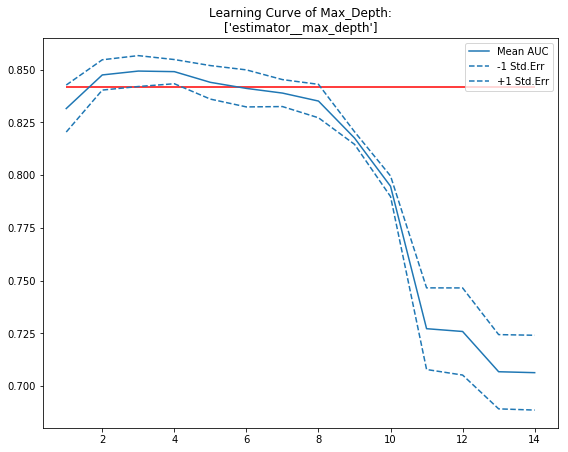

In [196]:
gbc.addIteration("Max_Depth", GradientBoostingClassifier(**gbc.parameters),
                {'estimator__max_depth': list(range(1,15))}, 
                 reg = True, plot = True)

gbc.parameters['max_depth'] = 2
gbc.parameters

## Iteration 3

Best Score: 0.848932

Best Params:  {'estimator__min_samples_leaf': 30}


{'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 30}

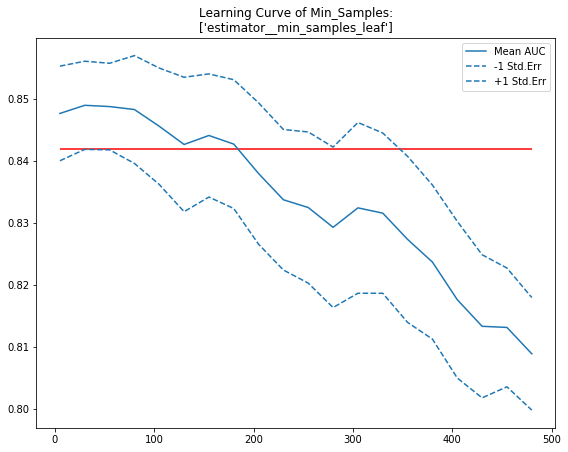

In [197]:
gbc.addIteration("Min_Samples", GradientBoostingClassifier(**gbc.parameters),
                {'estimator__min_samples_leaf': list(range(5,500,25))},
                 reg = True, plot = True)

gbc.parameters

## Iteration 4

Best Score: 0.850277

Best Params:  {'estimator__max_features': 24}


{'max_depth': 2,
 'max_features': 0.30434782608695654,
 'min_samples_leaf': 5,
 'n_estimators': 30}

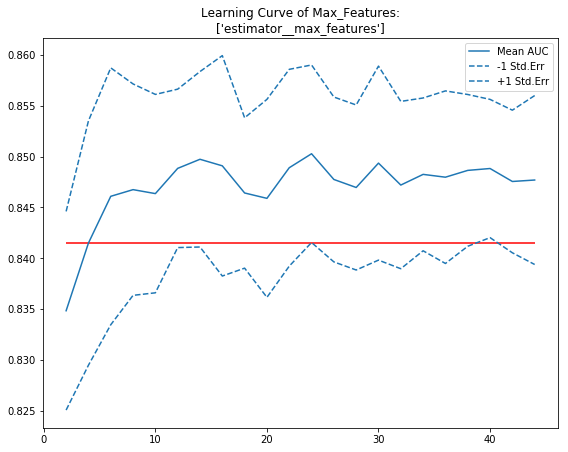

In [198]:
gbc.addIteration("Max_Features", GradientBoostingClassifier(**gbc.parameters),
                {'estimator__max_features': list(range(2,X_trained.shape[1],2))}, 
                 reg = True, plot = True)

gbc.parameters['max_features'] = gbc.parameters['max_features']/X_trained.shape[1]
gbc.parameters

## Iteration 5

Best Score: 0.852649

Best Params:  {'estimator__subsample': 0.80000000000000004}


{'max_depth': 2,
 'max_features': 0.30434782608695654,
 'min_samples_leaf': 5,
 'n_estimators': 30,
 'subsample': 0.85}

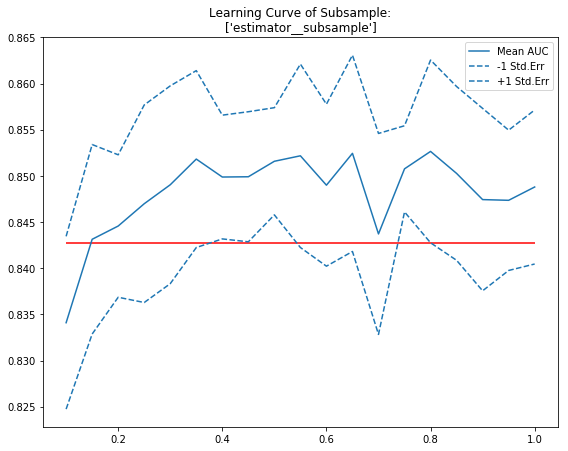

In [199]:
gbc.addIteration("Subsample", 
                GradientBoostingClassifier(**gbc.parameters),
                {'estimator__subsample': np.array(list(range(10,105,5)))/100}, 
                des = False, reg = True, plot = True)

gbc.parameters

## Interation 6 

Best Score: 0.861034

Best Params:  {'estimator__learning_rate': 0.01, 'estimator__n_estimators': 910}


{'learning_rate': 0.01,
 'max_depth': 2,
 'max_features': 0.30434782608695654,
 'min_samples_leaf': 5,
 'n_estimators': 760,
 'subsample': 0.85}

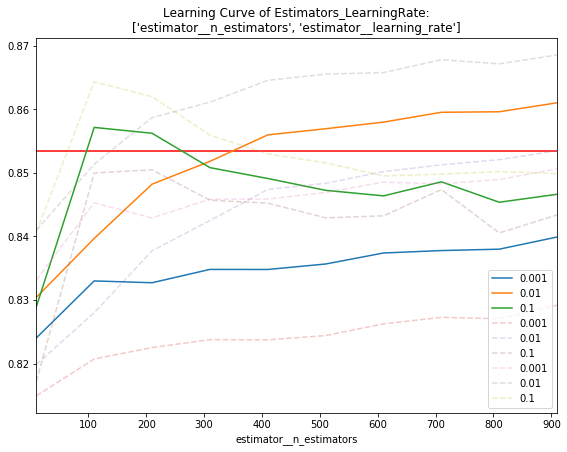

In [200]:
gbc.addIteration("Estimators_LearningRate",
                GradientBoostingClassifier(**gbc.parameters),
                {'estimator__n_estimators': list(range(10,1000,100)),
                 'estimator__learning_rate': [10**x for x in range(-3,0)]}, 
                 reg = True, plot = True)

gbc.parameters

## Iteration 7

Best Score: 0.861074

Best Params:  {'estimator__n_estimators': 1600}


{'learning_rate': 0.01,
 'max_depth': 2,
 'max_features': 0.30434782608695654,
 'min_samples_leaf': 5,
 'n_estimators': 1066,
 'subsample': 0.85}

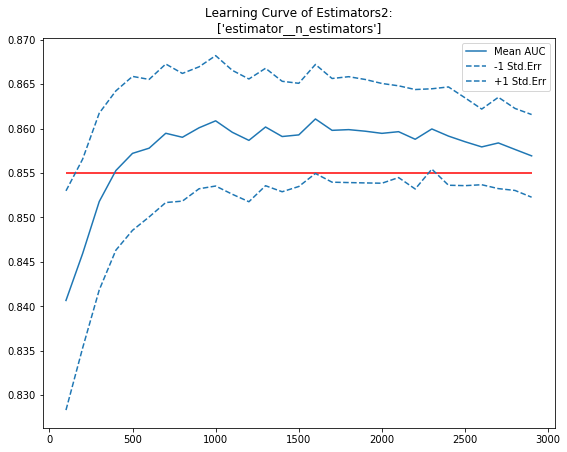

In [201]:
gbc.addIteration("Estimators2", 
                GradientBoostingClassifier(**gbc.parameters),
                {'estimator__n_estimators': list(range(100,3000,100))},
                reg = True, plot = True)

gbc.parameters

## Iteration 8

Best Score: 0.846225

Best Params:  {'feat_select__k': 12}


{'learning_rate': 0.01,
 'max_depth': 2,
 'max_features': 0.30434782608695654,
 'min_samples_leaf': 5,
 'n_estimators': 1066,
 'subsample': 0.85}

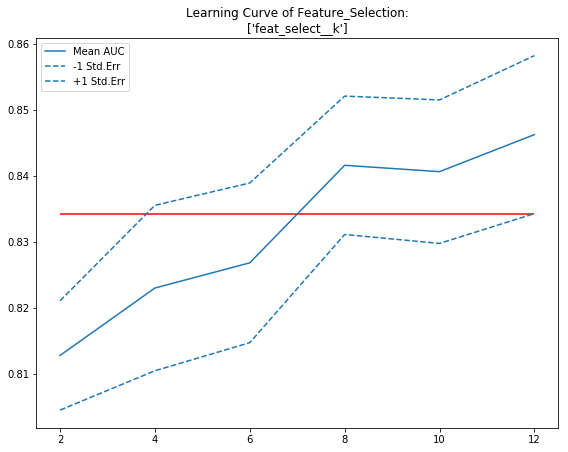

In [202]:
feature_pipeline = Pipeline([('feat_select', SelectKBest(mutual_info_classif, k = all)),
                             ('estimator', GradientBoostingClassifier(**gbc.parameters))])
                                    
gbc.addIteration("Feature_Selection", 
                GradientBoostingClassifier(**gbc.parameters),
                {'feat_select__k': list(range(2,int(gbc.parameters['max_features']*X_trained.shape[1]),2))},
                pipeline = feature_pipeline, 
                plot = True)

gbc.parameters

## GBC Compare 

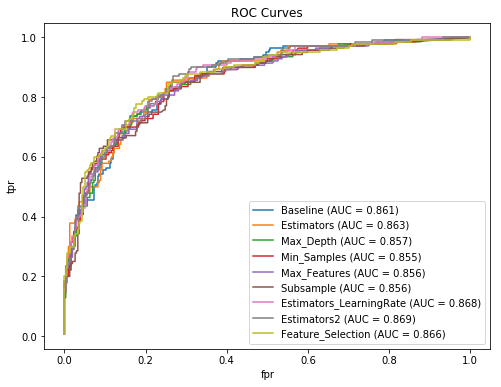

In [203]:
gbc.withinCompare()

# Random Forest

## Model Initialization

In [204]:
rdf = Model("RDF", RandomForestClassifier(random_state = 1234), X_trained, y_train, X_tested, y_test)

## Iteration 1

Best Score: 0.855078

Best Params:  {'estimator__n_estimators': 466}


{'n_estimators': 394}

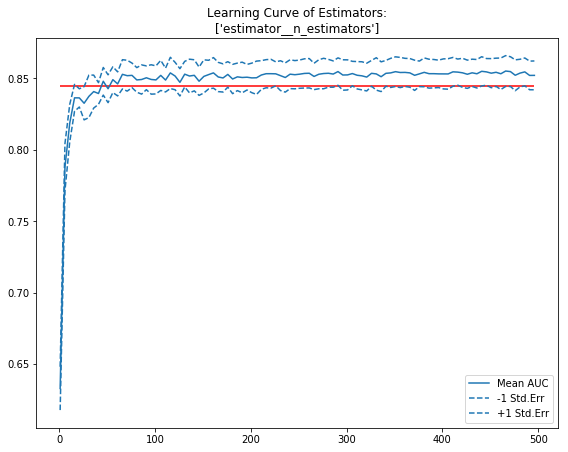

In [205]:
rdf.addIteration("Estimators", RandomForestClassifier(),
                {'estimator__n_estimators': list(range(1,500,5))}, 
                reg = True, plot = True)

rdf.parameters

## Iteration 2

Best Score: 0.85789

Best Params:  {'estimator__max_features': 17}


{'max_features': 0.2391304347826087, 'n_estimators': 394}

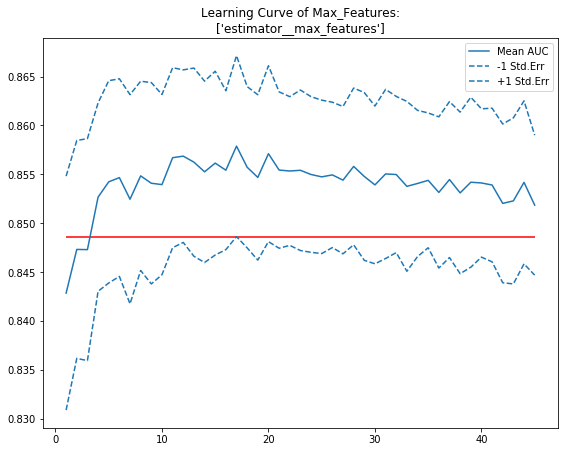

In [206]:
rdf.addIteration("Max_Features", RandomForestClassifier(**rdf.parameters),
                {'estimator__max_features': list(range(1,X_trained.shape[1],1))}, 
                reg = True, plot = True)

if rdf.parameters['max_features']:
    rdf.parameters['max_features'] = rdf.parameters['max_features']/X_trained.shape[1]
rdf.parameters

## Iteration 3

Best Score: 0.85737

Best Params:  {'estimator__min_samples_leaf': 2}


{'max_features': 0.2391304347826087,
 'min_samples_leaf': 2,
 'n_estimators': 394}

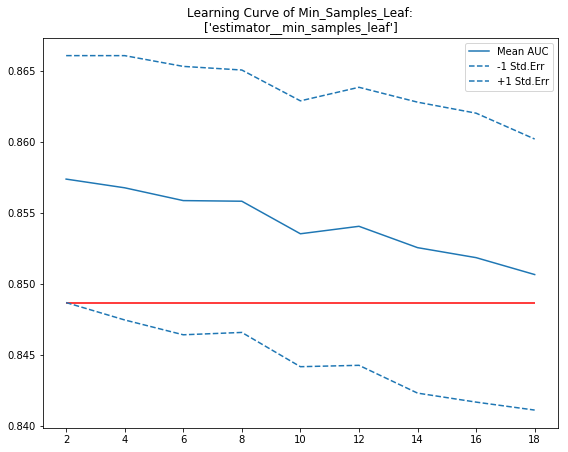

In [207]:
rdf.addIteration("Min_Samples_Leaf", RandomForestClassifier(**rdf.parameters),
                {'estimator__min_samples_leaf': list(range(2,20,2))}, 
                reg = True, plot = True)

rdf.parameters

## Iteration 4

Best Score: 0.859531

Best Params:  {'estimator__min_samples_split': 20}


{'max_features': 0.2391304347826087,
 'min_samples_leaf': 2,
 'min_samples_split': 16,
 'n_estimators': 394}

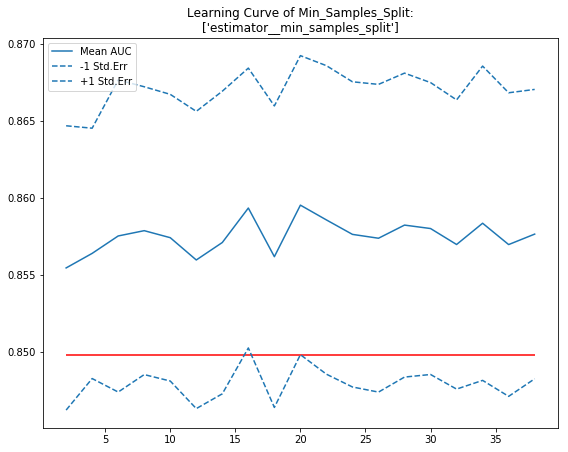

In [208]:
rdf.addIteration("Min_Samples_Split", RandomForestClassifier(**rdf.parameters),
                {'estimator__min_samples_split':list(range(2,40,2))}, 
                 reg = True, plot = True)

rdf.parameters

## Compare RDF

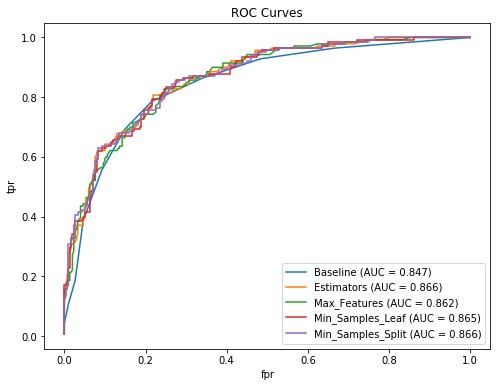

In [209]:
rdf.withinCompare()

# Dimension Reduction

## Model Initialization

In [210]:
gb1 = GradientBoostingClassifier(random_state = 1234)
pca1 = PCA(whiten = True, random_state = 1234)

pipe = Pipeline(steps=[('pca', pca1), ('boosted', gb1)])
pca1.fit(X_trained)

X_train_pca = pd.DataFrame(pca1.transform(X_trained))
X_test_pca = pd.DataFrame(pca1.transform(X_tested))

gbc_pca = Model("Dimension Reduction", pipe, X_train_pca, y_train, X_test_pca, y_test)

## Iteration 1

Best Score: 0.783382

Best Params:  {'estimator__pca__n_components': 45}


{'pca__n_components': 45}

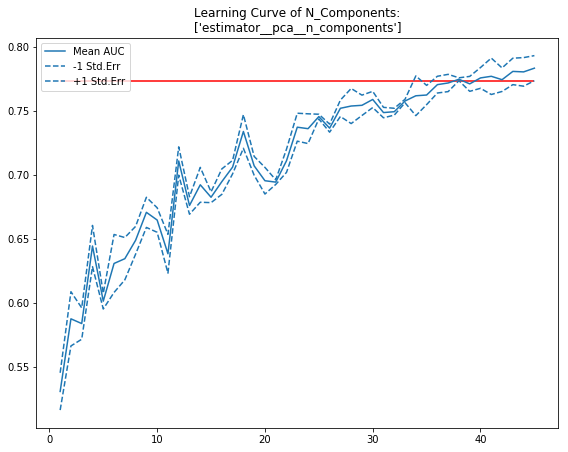

In [211]:
gbc_pca.addIteration("N_Components", pipe, 
                     dict(estimator__pca__n_components = list(range(1,X_train_pca.shape[1]))), 
                     reg = False, plot = True)

gbc_pca.parameters

## Iteration 2

Best Score: 0.790728

Best Params:  {'estimator__boosted__n_estimators': 90}


{'boosted__n_estimators': 90, 'pca__n_components': 45}

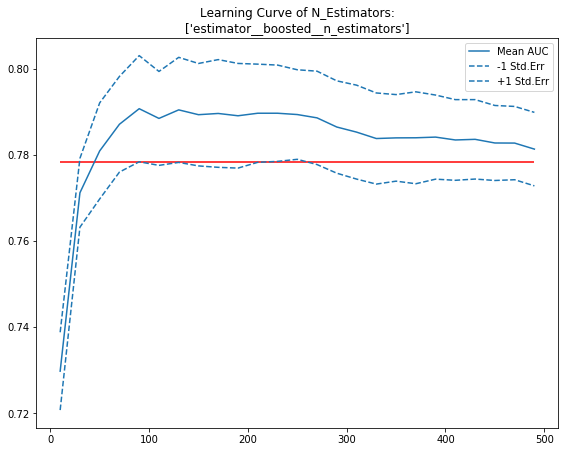

In [212]:
gb2 = GradientBoostingClassifier(**paramPipeline(["pca", "boosted"], gbc_pca)[1])
pca2 = PCA(whiten = True)
pca2.fit(X_trained)

gbc_pca.X_train = pd.DataFrame(pca2.transform(X_trained))
gbc_pca.X_test = pd.DataFrame(pca2.transform(X_tested))

pipe = Pipeline(steps=[('pca', pca2), ('boosted', gb2)])

gbc_pca.addIteration("N_Estimators", pipe, 
                     dict(estimator__boosted__n_estimators = list(range(10,500,20))), 
                     reg = False, plot = True)

gbc_pca.parameters

## Iteration 3

Best Score: 0.790946

Best Params:  {'estimator__boosted__max_depth': 3}


{'boosted__max_depth': 3,
 'boosted__n_estimators': 90,
 'max_depth': 2,
 'pca__n_components': 45}

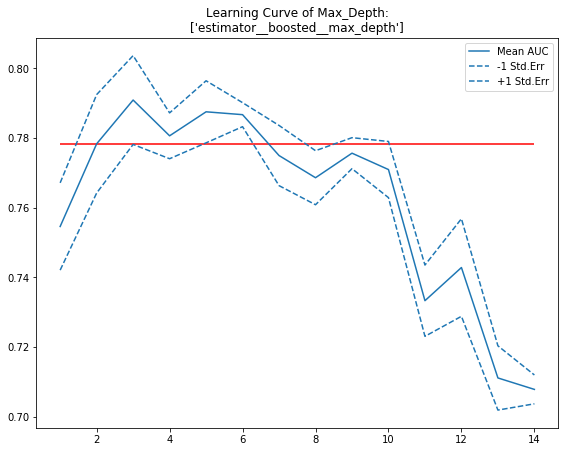

In [213]:
gb3 = GradientBoostingClassifier(**paramPipeline(["pca", "boosted"], gbc_pca)[1])

pipe = Pipeline(steps=[('pca', pca2), ('boosted', gb3)])

gbc_pca.addIteration("Max_Depth", pipe, 
                     dict(estimator__boosted__max_depth = list(range(1,15))), 
                     reg = False, plot = True)

gbc_pca.parameters['max_depth'] = 2
gbc_pca.parameters

## Iteration 4

Best Score: 0.793836

Best Params:  {'estimator__boosted__min_samples_leaf': 105}


{'boosted__max_depth': 3,
 'boosted__min_samples_leaf': 105,
 'boosted__n_estimators': 90,
 'max_depth': 2,
 'pca__n_components': 45}

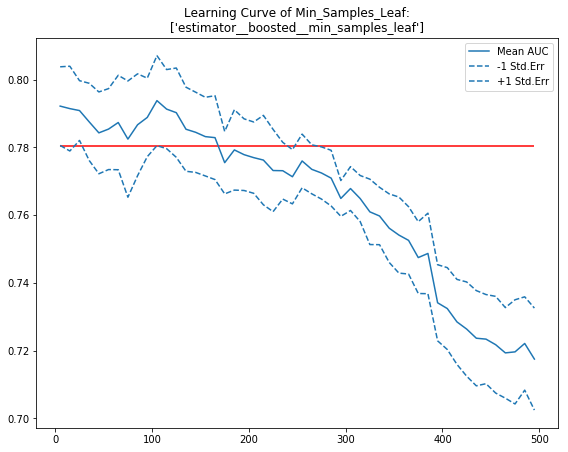

In [214]:
gb4 = GradientBoostingClassifier(**paramPipeline(["pca", "boosted"], gbc_pca)[1])

pipe = Pipeline(steps=[('pca', pca2), ('boosted', gb4)])

gbc_pca.addIteration("Min_Samples_Leaf", pipe, 
                     dict(estimator__boosted__min_samples_leaf = list(range(5,500,10))), 
                     reg = False, plot = True)

gbc_pca.parameters

## Iteration 5

Best Score: 0.79678

Best Params:  {'estimator__boosted__subsample': 0.59999999999999998}


{'boosted__max_depth': 3,
 'boosted__min_samples_leaf': 105,
 'boosted__n_estimators': 90,
 'boosted__subsample': 0.59999999999999998,
 'max_depth': 2,
 'pca__n_components': 45}

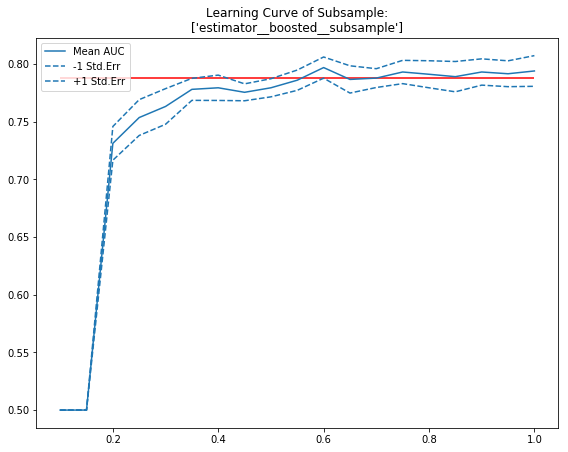

In [215]:
gb5 = GradientBoostingClassifier(**paramPipeline(["pca", "boosted"], gbc_pca)[1])

pipe = Pipeline(steps=[('pca', pca2), ('boosted', gb5)])

gbc_pca.addIteration("Subsample", pipe, 
                     dict(estimator__boosted__subsample = np.array(list(range(10,105,5)))/100), 
                     reg = False, plot = True)

gbc_pca.parameters

## Iteration 6

Best Score: 0.787896

Best Params:  {'estimator__boosted__learning_rate': 0.1}


{'boosted__learning_rate': 0.10000000000000001,
 'boosted__max_depth': 3,
 'boosted__min_samples_leaf': 105,
 'boosted__n_estimators': 90,
 'boosted__subsample': 0.59999999999999998,
 'max_depth': 2,
 'pca__n_components': 45}

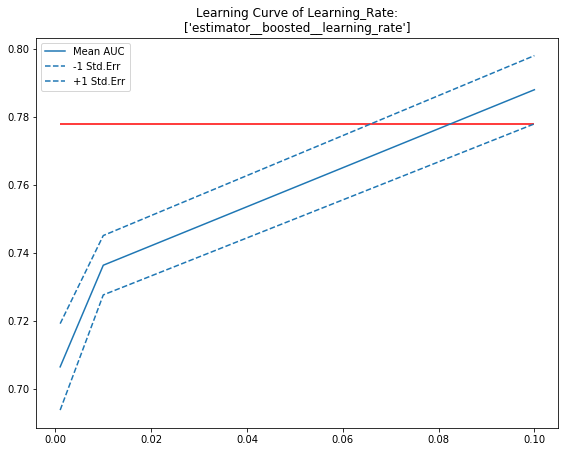

In [216]:
gb6 = GradientBoostingClassifier(**paramPipeline(["pca", "boosted"], gbc_pca)[1])

pipe = Pipeline(steps=[('pca', pca2), ('boosted', gb6)])

gbc_pca.addIteration("Learning_Rate", pipe, 
                     dict(estimator__boosted__learning_rate = [10**x for x in range(-3,0)]), 
                     reg = False, plot = True)

gbc_pca.parameters

## GBC_PCA Compare

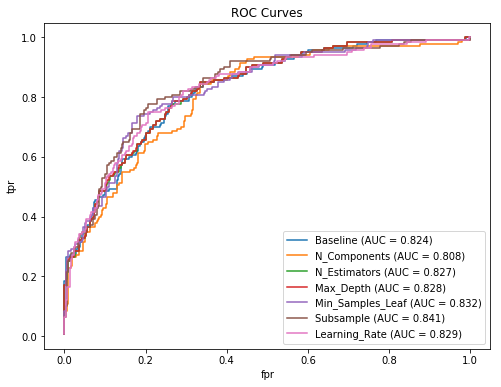

In [217]:
gbc_pca.withinCompare()

# SGD

## Model Initialization

In [218]:
sgd = Model("SGD", SGDClassifier(loss = "log", fit_intercept = True, random_state = 1234, max_iter = 5), 
            X_trained, y_train, X_tested, y_test)

sgd.parameters['loss']= "log"
sgd.parameters['fit_intercept'] = False
sgd.parameters['max_iter'] = 5

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


## Iteration 1

Best Score: 0.678142

Best Params:  {'estimator__alpha': 10}


{'fit_intercept': False, 'loss': 'log', 'max_iter': 5}

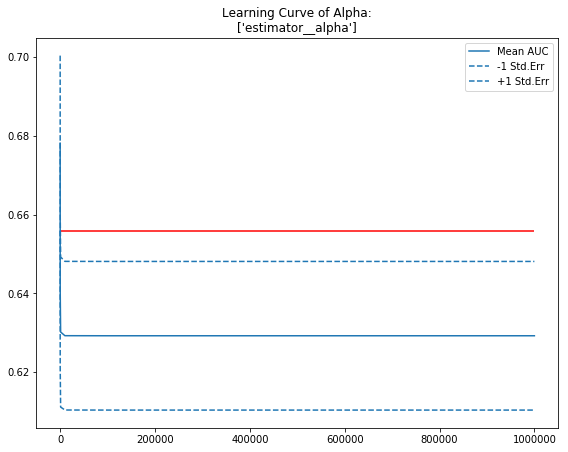

In [219]:
sgd.addIteration("Alpha", SGDClassifier(**sgd.parameters),
                 {'estimator__alpha': [10**x for x in range(1,7)]},
                 reg = True, plot = True)

sgd.parameters

## Iteration 2

Best Score: 0.697337

Best Params:  {'estimator__average': True}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


{'fit_intercept': False, 'loss': 'log', 'max_iter': 5}

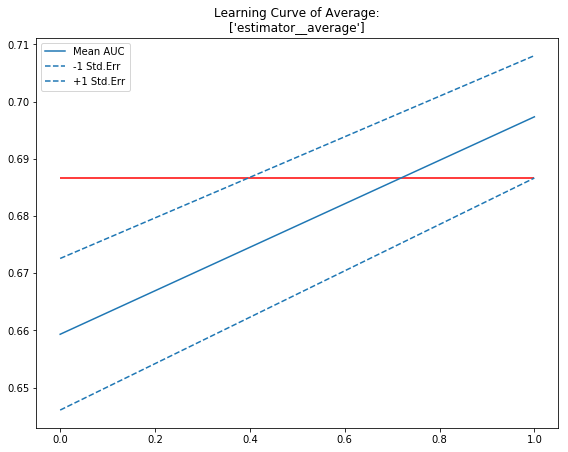

In [220]:
sgd.addIteration("Average", SGDClassifier(**sgd.parameters),
                 {'estimator__average': [False, True]})

sgd.parameters

## Iteration 3

Best Score: 0.727072

Best Params:  {'estimator__max_iter': 610}


{'fit_intercept': False, 'loss': 'log', 'max_iter': 5}

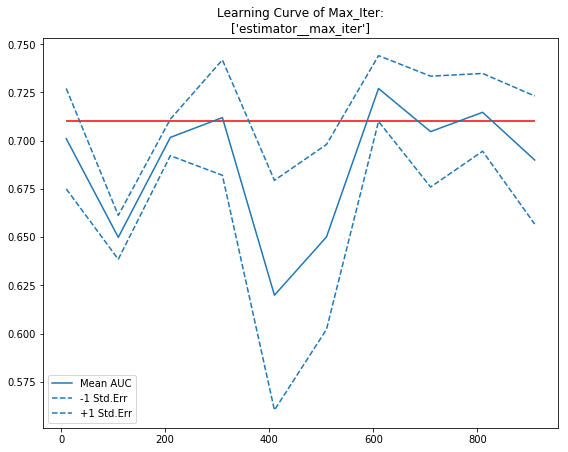

In [221]:
sgd.addIteration("Max_Iter", SGDClassifier(**sgd.parameters),
                 {'estimator__max_iter': list(range(10,1000,100))},
                 reg = True, plot = True)

sgd.parameters

## SGD Compare

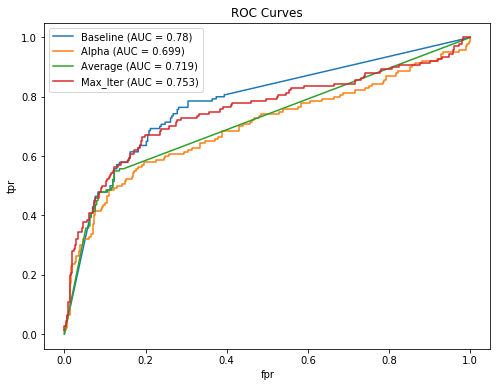

In [222]:
sgd.withinCompare()

# Model Comparison


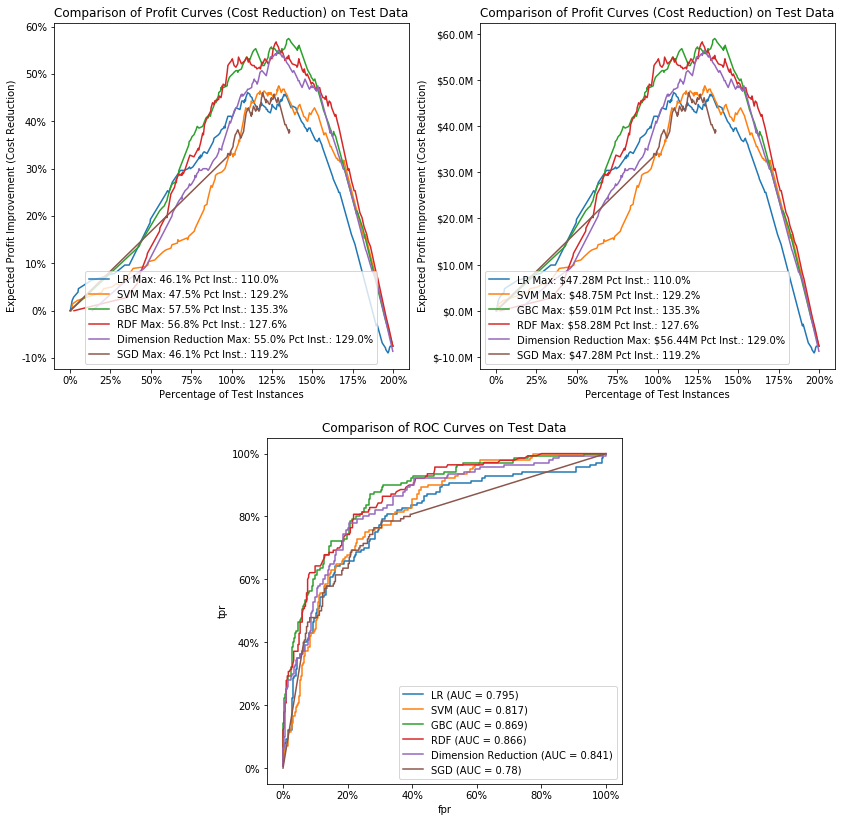

In [223]:
plotPerformance([lrc, svm, gbc, rdf, gbc_pca, sgd])